# TensorFlow2 教程-卷积变分自编码器


本教程通过构建卷积变分自编码器生成手写数字图片

首先先导入相关的库


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
print(tf.__version__)
from IPython import display

/home/doit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


## 一、载入MNIST数据集

MNIST数据是手写数字识别的图像数据集，是经典的深度学习数据集。其中每个图片大小为28*28，即可用一个784维的向量来表示图片。其中向量的每个数值在0-255之间，表示像素强度。
我们使用MNIST数据集来进行卷积变分自编码的实验，我们首先需要对图像数据进行预处理。这里我们使用伯努利分别来对所有像素进行建模，同时对数据集进行静态二值化处理。

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# 构建数据集

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 化到0-1之间
train_images /= 255.0
test_images /= 255.0

# 二值化
train_images[train_images>=0.5] = 1.0
train_images[train_images<0.5] = 0.0
test_images[test_images>=0.5] = 1.0
test_images[test_images<0.5] = 0.0

#　超参数
ＴRAIN_BUF=60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [4]:
# 分批和打乱数据


train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)


## 二、构建生成网络和推理网络

我们使用卷积网络来构建生成网络和推理网络。并使用x和z分别表示观测值和潜在变量
#### 生成网络
生成网络将隐变量作为输入，并输出用于观测条件分布的参数p(x|z).我们对隐变量使用单位高斯先验分布。
#### 推理网络
这里定义了近似后验分布q(z|x) ，该后验分布以观测值作为输入，并输出用于潜在表示的条件分布的一组参数。在本示例中，我们仅将此分布建模为对角高斯模型。在这种情况下，推断网络将输出因式分解的高斯均值和对数方差参数
#### 采样
我们从q(z|x)中采样，方法是先从单位高斯中采样，然后乘以标注差并加上平均值。这样可以确保梯度能确保梯度能传回推理网络。
#### 网络结构
对于推理网络，我们使用了两个卷积层加一个全连接层，而对于生成网络，我们使用全连接层加3个反卷积层。
注意：训练VAE过程中要避免使用批归一化，因为这样会导致额外的随机性，从而加剧随机抽样的不稳定性


In [5]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim+latent_dim)
        ])
        self.generative_net = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2),
                padding='SAME', activation='relu'
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2),
                padding='SAME', activation='relu'
            ),
            # 不使用激活函数
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1),
                padding='SAME'
            ),
            
        ])
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2,
                               axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

### 三、定义损失函数和优化器

VAE 通过最大化边际对数似然的证据下界（ELBO）进行训练：
$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

实际上，我们优化了此期望的单样本蒙卡特罗估计：

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
其中 $z$ 从 $q(z|x)$ 中采样。

注意：我们也可以分析性地计算 KL 项，但简单起见，这里我们将所有三个项合并到蒙卡特罗估计器中。

In [6]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
    -0.5*((sample -mean)**2.0 * tf.exp(-logvar)+logvar+log2pi),
        axis=raxis
    )

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logpz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z+logpz-logpz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))




### 四、训练
我们从迭代数据集开始：
- 在每次迭代期间，我们将图像传递给编码器，以获得近似后验q(z|x)  的一组均值和对数方差参数。
- 然后，我们从 q(z|x) 中采样分布。

- 最后，我们将重新参数化的样本传递给解码器，以获取生成分布 p(x|z) 的 logit。

注意：由于我们使用的是由 keras 加载的数据集，其中训练集中有 6 万个数据点，测试集中有 1 万个数据点，因此我们在测试集上的最终 ELBO 略高于对 Larochelle 版 MNIST 使用动态二值化的文献中的报告结果。


### 五、生成图片
- 进行训练后，可以生成一些图片了
- 我们首先从单位高斯先验分布 p(z) 中采样一组隐向量z
- 随后生成器将隐向量z 转换为观测值的 logit，得到分布 p(x|z)
- 这样我们就可以得到生成的图片

In [7]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# 保持随机向量恒定以进行生成（预测），以便看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [8]:
# 使用输入生成图片
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout 最小化两个子图之间的重叠
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

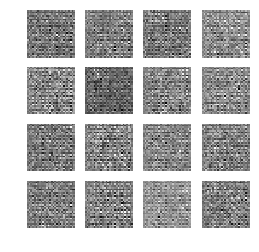

In [9]:
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 100, Test set ELBO: -77.73490905761719, time elapse for current epoch 27.509661436080933


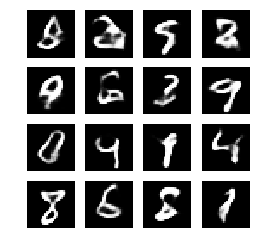

In [10]:
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)
        

In [12]:
### 五、生成图片
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

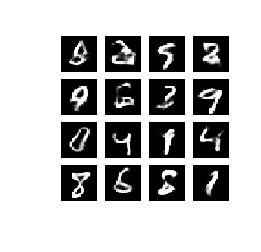

In [13]:
plt.imshow(display_image(epochs))
plt.axis('off')# 显示图片

In [16]:
# 生成gif
anim_file = 'cvae.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)